In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
import PIL
import pathlib
import splitfolders
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Starting Thinking about Data & Distribution of Data**


In [ ]:
splitfolders.ratio("drive/MyDrive/Data/Model Dataset", output="drive/MyDrive/Data/", ratio=(.8, .2))

Copying files: 6589 files [02:09, 50.82 files/s]


In [ ]:
data_dir_train = pathlib.Path( 'drive/MyDrive/Data/Train/')
img_height,  img_width  = 224, 224

In [ ]:
train_ds = image_dataset_from_directory(data_dir_train,
                                        seed = 123,
                                        image_size=(img_height, img_width))

Found 19801 files belonging to 5 classes.


In [ ]:
class_names = train_ds.class_names

In [ ]:
class_names

['Acne', 'Atopic Dermatitis', 'Bullous Dieases', 'cancer', 'other']

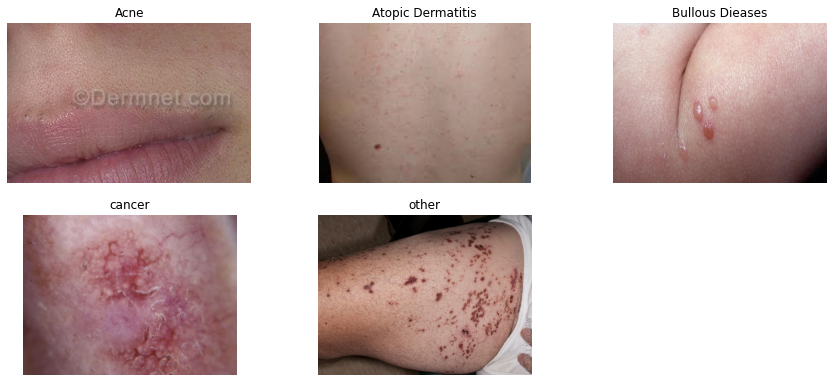

In [ ]:
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.*'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [ ]:
class_size = {}
for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.*')))

class_size

{'Acne': 1779,
 'Atopic Dermatitis': 1747,
 'Bullous Dieases': 3804,
 'cancer': 7200,
 'other': 5272}

In [ ]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
Acne,1779
Atopic Dermatitis,1747
Bullous Dieases,3804
cancer,7200
other,5272


#**Rectify the class imbalance**


Python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples

Instantiate a Pipeline object pointing to a directory containing your initial image data set.

Define a number of operations to perform on this data set using your Pipeline object.

Execute these operations by calling the Pipeline’s sample() method.


###**Main Feature of our work**


*   Perspective Skewing
*   Elastic Distortions
*   Cropping
*   Mirroring
*   Rotating
*   Shearing



In [ ]:
!pip install Augmentor

In [ ]:
import Augmentor

In [ ]:
path_to_training_dataset = 'drive/MyDrive/Data/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory='')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

##**Bulid our model**

In [ ]:
batch_size = 32
epochs = 500
img_size = 224

In [ ]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                  rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,
                               # horizontal flip
                                   brightness_range=[0.2,0.8])

test_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])
#training_set = train_datagen.flow_from_directory('drive/MyDrive/Data/Train/',
 #                                                target_size=(224,224),
  #                                               batch_size=32)

#test_set = test_datagen.flow_from_directory('drive/MyDrive/Data/Val/',
   #                                         target_size=(224,224),
    #                                        batch_size=32,
     #                                       shuffle=False)

In [ ]:
def Xception():

    engine = tf.keras.applications.Xception(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (img_size , img_size , 3),

    )


    x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
    x =Dropout(0.75)(x)
    x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                      beta_regularizer=None,
                      gamma_regularizer=None,
                      beta_constraint=None,
                      gamma_constraint=None,

                  )(x)

    out = tf.keras.layers.Dense(5, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model

    model = tf.keras.models.Model(inputs = engine.input, outputs = out)
    # Compile the model

    model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        # Set metrics to accuracy
        metrics = ['accuracy']
    )

    return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience=2,
                                                            verbose=2,
                                                            factor=0.5,
                                                            min_lr=0.00001)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
filepath = 'drive/MyDrive/Models/mymodel-best.ckpt'
checkpoint = ModelCheckpoint(filepath , save_best_only= True, monitor = 'val_accuracy')

In [ ]:
 def train():
    time_start = time.time()

    model = Xception()

    model.summary()
    history = model.fit(training_set, epochs= 500 ,validation_data = test_set,
                       callbacks=[early_stopping, reduce_lr , learning_rate_reduction,checkpoint]
                        )



    model.save_weights('drive/MyDrive/DermAI/Models/categories/category.h5')
    model.save('drive/MyDrive/DermAI/Models/categories/category.h5')

    print('Model saved.')

    time_end = time.time()
    print('Training Time:', time_end - time_start)
    print('\n')

    return history

In [ ]:
def test():
    #test_labels = np.array(test_labels)

    from tensorflow import keras
    print('Testing:')
    mod =  keras.models.load_model('drive/MyDrive/DermAI/Models/categories/category.h5')
    mod.evaluate(test_set)

    prob = mod.predict(test_set)
    predIdxs = np.argmax(prob, axis=1)


    print('\n')
    print(classification_report(test_set.labels, predIdxs,target_names = key, digits=5))
    return  prob, predIdxs, mod

In [ ]:
input_path = 'drive/MyDrive/Data/Val/'
train_data = image_dataset_from_directory(directory=input_path,
                                              batch_size=32,
                                              image_size=(224, 224))

In [ ]:
if __name__ == "__main__":

    key = train_data.class_names
    train_history = train()
    prob, predIdxs, model= test()


Testing:
165/165 [==============================] - 110s 658ms/step - loss: 0.1965 - accuracy: 0.9595


                   precision    recall  f1-score   support

             Acne    0.88539   0.85652   0.87072       460
Atopic Dermatitis    0.91275   0.92727   0.91995       440
  Bullous Dieases    0.98919   0.99002   0.98960      1202
           cancer    0.99889   1.00000   0.99944      1800
            other    0.93805   0.94152   0.93979      1351

         accuracy                        0.96402      5253
        macro avg    0.94486   0.94307   0.94390      5253
     weighted avg    0.96387   0.96402   0.96392      5253



# **Final Test & Evaluation**

In [ ]:
input_path = 'drive/MyDrive/DermAI/Models/categories/testset/'
test = image_dataset_from_directory(directory=input_path,
                                              batch_size=32,
                                              image_size=(224, 224))
key = test.class_names

Found 5154 files belonging to 5 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('drive/MyDrive/DermAI/Models/categories/testset',
                                            target_size=(224,224),
                                            batch_size=32,
                                            shuffle=False)

Found 5154 images belonging to 5 classes.


In [ ]:
 prob, predIdxs, model= test()

Testing:
162/162 [==============================] - 4331s 27s/step - loss: 0.1798 - accuracy: 0.9659


                   precision    recall  f1-score   support

             Acne    0.90160   0.85652   0.87848       460
Atopic Dermatitis    0.90200   0.92045   0.91114       440
  Bullous Dieases    0.99133   0.98451   0.98791      1162
           cancer    0.99889   1.00000   0.99944      1800
            other    0.92912   0.94350   0.93625      1292

         accuracy                        0.96275      5154
        macro avg    0.94459   0.94100   0.94265      5154
     weighted avg    0.96274   0.96275   0.96267      5154



##**Implementation confusion_matrix**


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
cm = confusion_matrix(test_set.labels, predIdxs)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = key,
                     columns =key)

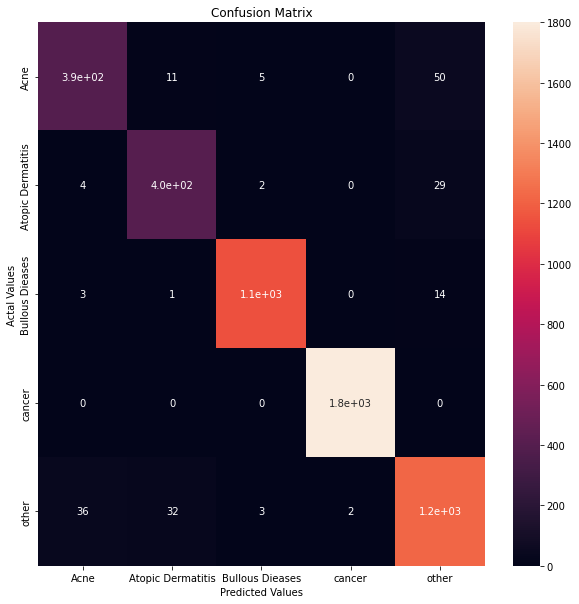

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


# **threshold 0.10%**

In [ ]:
test_labels = test_set.labels

In [ ]:
test_labels = test_set.labels
def dermai_accuracy(prob, prob_Desicon):
    dermai = []
    for i in range(len(prob)):
        catogery =[]
        for j in range(len(prob[i])):
            if prob[i][j] > prob_Desicon:
                catogery.append(j)
        dermai.append(catogery)
    Positive = []
    for i in range(len(dermai)):
        if test_labels[i] in dermai[i]:
            Positive.append(1)
    accuracy = (len(Positive)/len(test_labels))*100
    return  accuracy,dermai

In [ ]:
accuracy,dermai = dermai_accuracy(prob, 0.10)

In [ ]:
accuracy

97.28366317423361

## **Save Arc Model & labelling clases**

In [ ]:
category = 'drive/MyDrive/DermAI/Models/Categories/labels.json'
import json
aDict ={}
for i in range(len(key)):
    aDict[key[i]] = i
jsonFile = open(category, "w")
jsonString = json.dumps(aDict)
jsonFile.write(jsonString)
jsonFile.close()

In [ ]:
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('drive/MyDrive/DermAI/Models/Categories/Category_Arch.json', 'w') as json_file:
    json_file.write(json_model)